# Numerical simulation of FAST applied to a generic image from scikit-image


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import fast.s26_analysis.utils as utils 
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
import skimage
from tqdm.notebook import tqdm
import tifffile as tif
import joblib

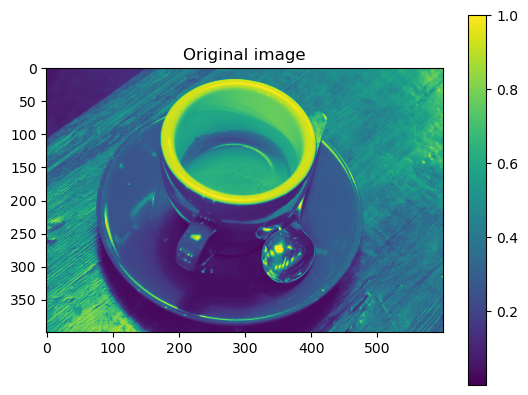

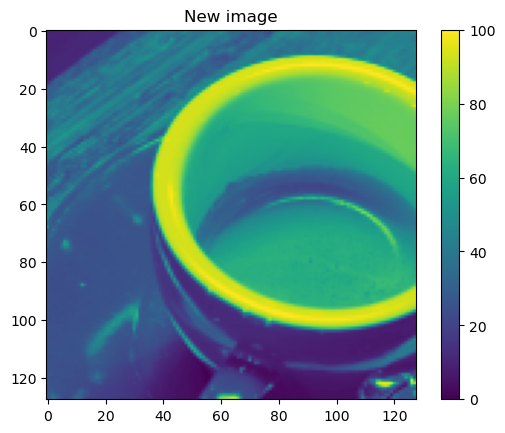

In [3]:
# Taking a generic image, then cropping and rescaling it
coffee = skimage.color.rgb2gray(skimage.data.coffee())

plt.figure()
plt.imshow(coffee)
plt.title('Original image')
plt.colorbar()
plt.show()

# Taking a smaller section and rescaling
coffee = skimage.transform.resize(coffee[:256,100:356], (128, 128))

# normalizing
coffee = (coffee - coffee.min()) / (coffee.max() - coffee.min()) * 100

plt.figure()
plt.imshow(coffee)
plt.title('New image')
plt.colorbar()
plt.show()

### Simulating the FAST procedure only

In [4]:
# Get a 1% measurement mask
init_pattern = gcn(*coffee.T.shape, 0.01)

Initial ratio is 0.00994873046875


Text(0.5, 1.0, 'Initial scan pattern')

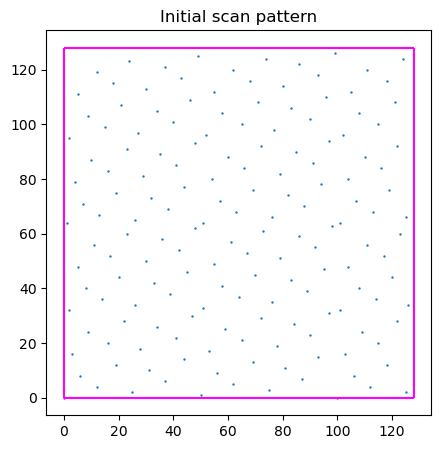

In [5]:
plt.figure(figsize=[5, 5])
plt.scatter(init_pattern[:,1], init_pattern[:,0], s=0.5)
plt.vlines([0, 128], ymin=0, ymax=128, color='magenta')
plt.hlines([0, 128], xmin=0, xmax=128, color='magenta')
plt.gca().set_aspect('equal')
plt.title('Initial scan pattern')

In [10]:
Path.cwd()

PosixPath('/Users/skandel/code/fast_smart_scanning/work_directory/training_usc_sipi')

In [16]:
# Specifying the trained nn model to use
# We use the model generated for c=2.
models_to_test = {'cameraman': '/Users/skandel/code/fast_smart_scanning/work_directory/training/cameraman/c_2/erd_model_relu.pkl',
                  'generic': '/Users/skandel//code/fast_smart_scanning/work_directory/training_usc_sipi/selected_images/c_2/erd_model_relu.pkl'}

In [56]:
masks_all = []
recons_fast_all = []
ratios_all = []
tot_erds_all = []
samples_all = []
for key in models_to_test:
    sample_this = utils.create_experiment_sample(numx=coffee.shape[1], numy=coffee.shape[0],
                                        inner_batch_size=50,
                                        initial_idxs=init_pattern,
                                        erd_model_file_path=models_to_test[key])
    masks_this = []
    recons_fast_this = []
    ratios_this = []
    tot_erds_this = []
    
    count = 0
    new_idxs = init_pattern

    n_scan_points = int(0.8 * coffee.size)
    pbar = tqdm(total=n_scan_points, desc='Scanned points')
    # Continue until we measure 40% of the points.
    while sample_this.mask.sum() < n_scan_points:
        # Supply the measurement values.
        sample_this.measurement_interface.finalize_external_measurement(coffee[new_idxs[:,0], new_idxs[:,1]])

        # Supply in measurement positions
        sample_this.perform_measurements(new_idxs)

        # Use the measurement values to reconstruct the sample and calculate the ERDs
        sample_this.reconstruct_and_compute_erd()

        # Compute new positions.
        new_idxs = sample_this.find_new_measurement_idxs()[:50]

        ratio = sample_this.ratio_measured
        ratios_this.append(ratio)
        tot_erds_this.append(sample_this.ERD.sum())
        recons_fast_this.append(sample_this.recon_image.copy())
        masks_this.append(sample_this.mask.copy())
        pbar.update(int(sample_this.mask.sum() - pbar.n))
        
    masks_all.append(masks_this)
    recons_fast_all.append(recons_fast_this)
    ratios_all.append(ratios_this)
    tot_erds_all.append(tot_erds_this)
    samples_all.append(sample_this)
    

Scanned points:   0%|          | 0/13107 [00:00<?, ?it/s]

Scanned points:   0%|          | 0/13107 [00:00<?, ?it/s]

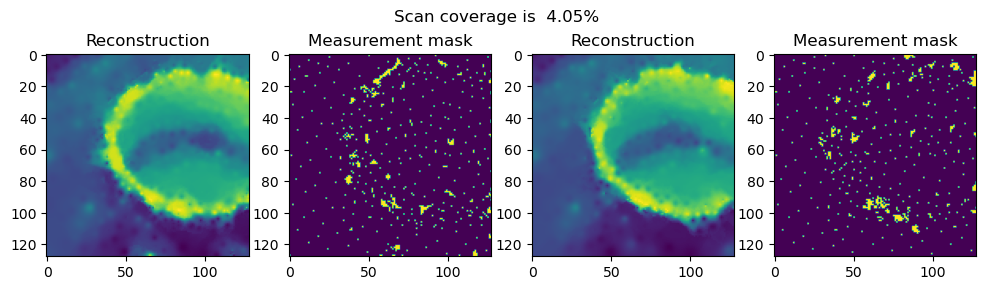

[0.39560217972247946, 0.38821439261240104]
[20.177206545660297, 19.98328730784862]


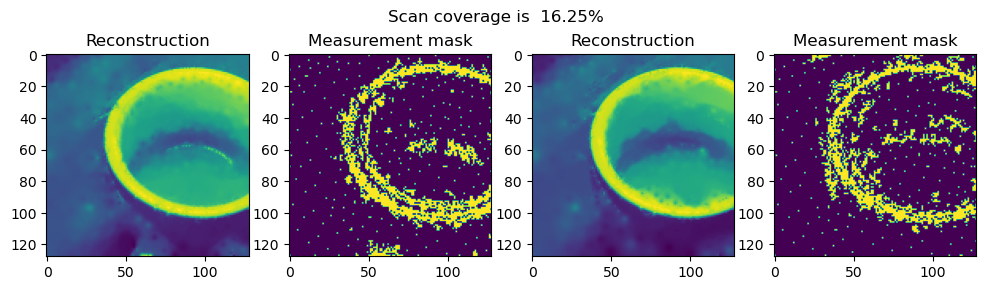

[0.5421055737496605, 0.5156692786157402]
[25.17750006345505, 22.84222307004216]


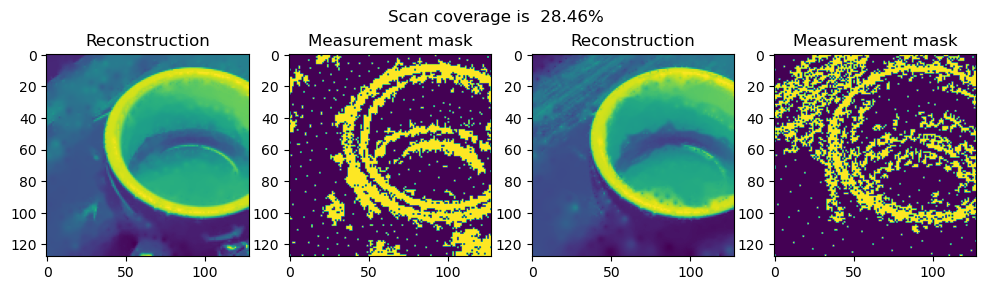

[0.6461224488898818, 0.6287277098076949]
[28.650241175410912, 24.035380200702892]


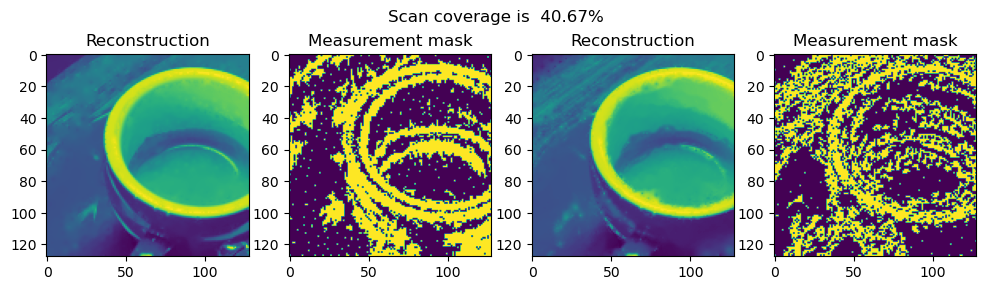

[0.74997175267032, 0.7405629863947244]
[33.850084470417386, 26.79664107339818]


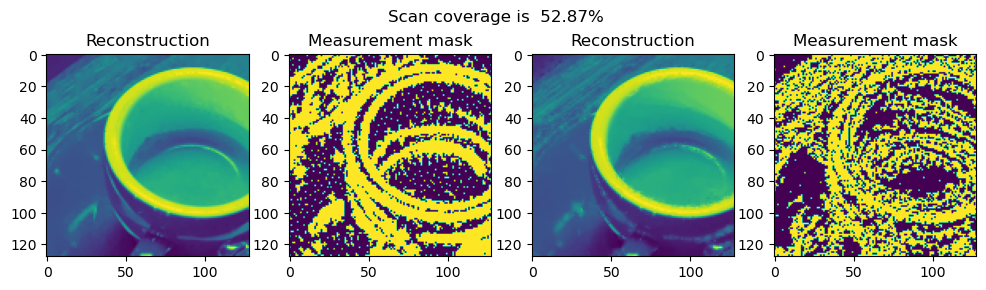

[0.8596335074112506, 0.8358182039606777]
[39.10668563348124, 31.111723004448486]


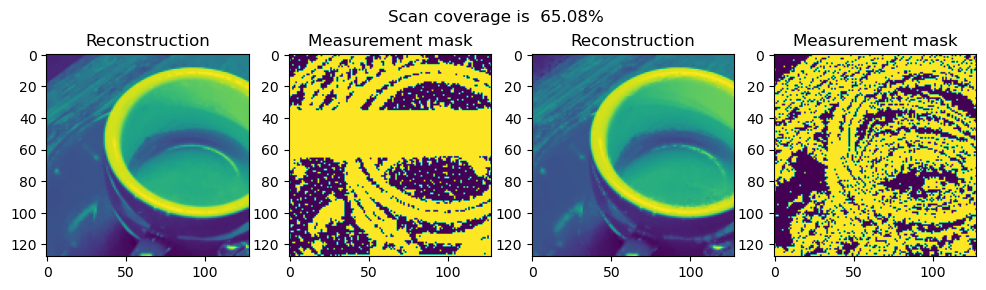

[0.895136069906027, 0.8926694312232007]
[41.2632567038409, 32.81055103689472]


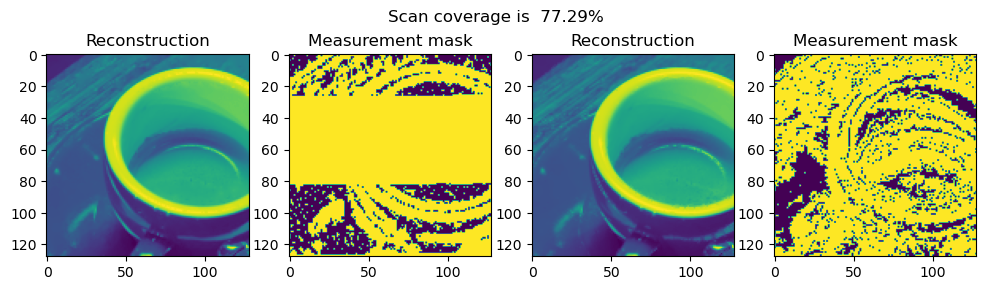

[0.9380450641568292, 0.9283068550413129]
[42.70098023423253, 36.6510325087674]


In [57]:
ssims = []
psnrs = []
rmses = []
for n, ix in enumerate(range(10, len(ratios_all[0]), 40)):
    ssims_this = []
    psnrs_this = []
    rmses_this = []
    fig = plt.figure(figsize=[12, 3])
    for iy in range(2):
        plt.subplot(1, 4, iy* 2 + 1)
        plt.imshow(recons_fast_all[iy][ix])
        plt.title('Reconstruction')
        
        ssims_this.append(skimage.metrics.structural_similarity(coffee, recons_fast_all[iy][ix]))
        psnrs_this.append(skimage.metrics.peak_signal_noise_ratio(coffee, recons_fast_all[iy][ix], data_range=100))
        rmses_this.append(skimage.metrics.normalized_root_mse(coffee, recons_fast_all[iy][ix]))
        
        plt.subplot(1, 4, iy*2 + 2)
        plt.imshow(masks_all[iy][ix])
        plt.title('Measurement mask')
        
    plt.suptitle(f'Scan coverage is {ratios_all[0][ix] * 100: 3.2f}%')
    plt.show()
    print(ssims_this)
    print(psnrs_this)
    
    ssims.append(ssims_this)
    psnrs.append(psnrs_this)
    rmses.append(rmses_this)

We can see that the 22% reconstruction captures the esssential features

In [58]:
ssims = np.array(ssims)
psnrs = np.array(psnrs)
nrmses = np.array(rmses)

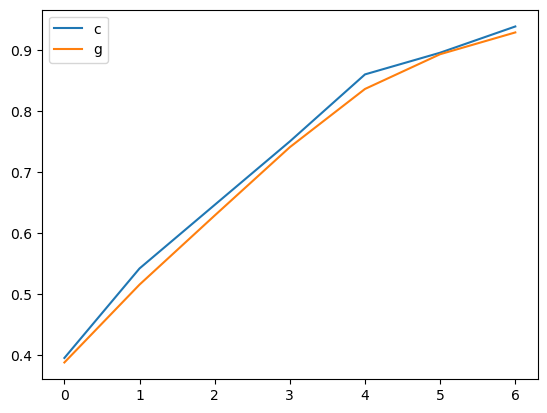

In [59]:
plt.plot(ssims[:,0], label='c')
plt.plot(ssims[:,1], label='g')
plt.legend(loc='best')

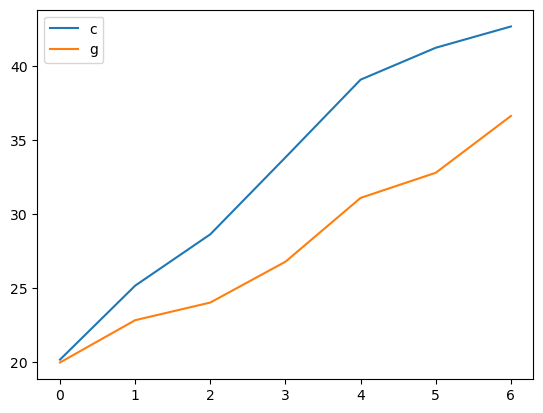

In [60]:
plt.plot(psnrs[:,0], label='c')
plt.plot(psnrs[:,1], label='g')
plt.legend(loc='best')

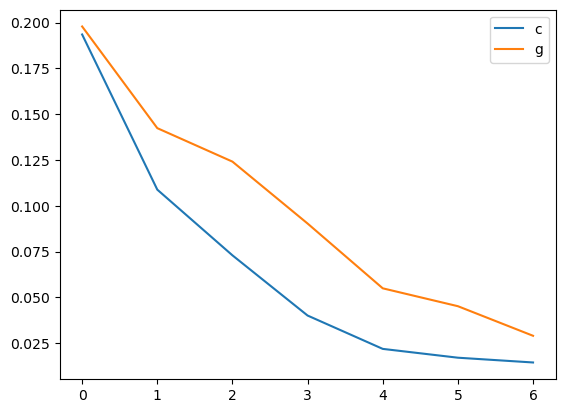

In [61]:
plt.plot(nrmses[:,0], label='c')
plt.plot(nrmses[:,1], label='g')
plt.legend(loc='best')